# Extreme multi-class classification

ID2223 Scalable Machine Learning and Deep Learning

**Federico Baldassarre (fedbal@kth.se)** 

**Beatrice Ionascu (bionascu@kth.se)**

In [40]:
%matplotlib inline

import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

plt.rcParams['figure.figsize'] = (15, 5)

# add the 'src' directory so we can import modules
sys.path.append('../src')

from utils.paths import data_raw_dir, data_processed_dir

## Problem
- [Cdiscount](https://www.cdiscount.com/) is France’s largest non-food e-commerce company
- Product classification based on their images is challenging (12M+ images and 5000+ classes)
- The dataset is severly imbalanced

## Data set

![data](./data.png)

In [41]:
categories = pd.read_pickle(
    os.path.join(data_processed_dir, 'categories.pickle'))
def categories_example():
    display(HTML(
        categories.filter(like='category', axis=1).head().to_html(index=False)))

In [42]:
categories_example()

category_id,category_level1,category_level2,category_level3
1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA
1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR
1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO
1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU
1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR


In [43]:
product_distrib = pd.read_pickle(os.path.join(data_processed_dir, 'cat_id_prod_distrib.pickle'))
image_distrib = pd.read_pickle(os.path.join(data_processed_dir, 'cat_id_img_distrib.pickle'))
categ_counts = pd.read_csv(os.path.join(data_raw_dir, 'category_names.csv'))

In [44]:
print('There are {} products'.format(product_distrib.sum()))
print('There are {} images'.format(image_distrib.sum()))
categ_counts.nunique().to_frame('Category counts')

There are 7069896 products
There are 12371293 images


,Category counts
category_id,5270
category_level1,49
category_level2,483
category_level3,5263


The 7M+ products are unevenly distributed among the 5270 categories:
- many categories contain very few product examples
- few categories contain the largest part of the products

In [45]:
cat_id_distrib = pd.read_pickle(os.path.join(data_processed_dir, 'cat_id_prod_distrib.pickle'))
cat_1_distrib = pd.read_pickle(os.path.join(data_processed_dir, 'cat_1_prod_distrib.pickle'))
cat_2_distrib = pd.read_pickle(os.path.join(data_processed_dir, 'cat_2_prod_distrib.pickle'))
cat_3_distrib = pd.read_pickle(os.path.join(data_processed_dir, 'cat_3_prod_distrib.pickle'))

def histograms():    
    fig, ax = plt.subplots(2, 2, figsize=(16, 8))
    ax=ax.ravel()
    cat_1_distrib.hist(log=True, bins=50,ax=ax[0])
    ax[0].set_title('Category Level 1 ({})'.format(cat_1_distrib.size))
    cat_2_distrib.hist(log=True, bins=50,ax=ax[1])
    ax[1].set_title('Category Level 2 ({})'.format(cat_2_distrib.size))
    cat_3_distrib.hist(log=True, bins=50,ax=ax[2])
    ax[2].set_title('Category Level 3 ({})'.format(cat_3_distrib.size))
    cat_id_distrib.hist(log=True, bins=50,ax=ax[3])
    ax[3].set_title('Category id ({})'.format(cat_id_distrib.size))
    for a in ax[2:]: a.set_xlabel('Number of products')

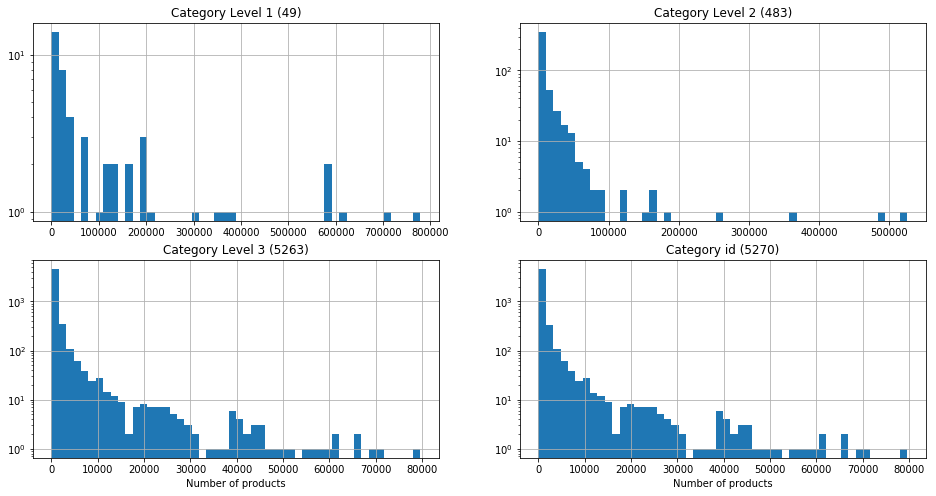

In [46]:
histograms()

Categories containing the most products:

In [47]:
def top5():
    display(HTML(
        pd.merge(categories.filter(like='category'), 
         cat_id_distrib.sort_values(ascending=False).head().to_frame('product counts'),
         left_index=True, right_index=True).sort_values('product counts', ascending=False)
        .to_html(index=False)))

In [48]:
top5()

category_id,category_level1,category_level2,category_level3,product counts
1000018296,MUSIQUE,CD,CD POP ROCK - CD ROCK INDE,79640
1000011423,INFORMATIQUE,IMPRESSION - SCANNER,TONER - RECUPERATEUR DE TONER,71116
1000011427,INFORMATIQUE,IMPRESSION - SCANNER,CARTOUCHE IMPRIMANTE,69784
1000014202,LIBRAIRIE,LITTERATURE,LITTERATURE FRANCAISE,65642
1000015309,LIBRAIRIE,AUTRES LIVRES,AUTRES LIVRES,65435


Categories containing the least products:

In [49]:
def bottom5():
    display(HTML(
        pd.merge(categories.filter(like='category'), 
         cat_id_distrib.sort_values(ascending=False).tail().to_frame('product counts'),
         left_index=True, right_index=True).sort_values('product counts', ascending=False)
        .to_html(index=False)))

In [50]:
bottom5()

category_id,category_level1,category_level2,category_level3,product counts
1000015609,CHAUSSURES - ACCESSOIRES,ACCESSOIRES CHAUSSURES,ESSUIE-BOTTES - LAVE-BOTTES,12
1000013297,ELECTRONIQUE,CAPTEURS,SYSTEME DE SURVEILLANCE DE NIVEAU,12
1000008894,JEUX - JOUETS,JONGLERIE,ASSIETTE CHINOISE,12
1000019804,SPORT,BASEBALL,BLOUSON DE BASEBALL - VESTE DE BASEBALL,12
1000020847,TV - VIDEO - SON,PROTECTION - ENTRETIEN,HOUSSE POUR ENREGISTEUR - HOUSSE POUR DICTAPHO...,12


## Approach
### Transfer Learning
- Reuse the architecture and the weights of another network to extract a representation of the images
- This representation contains useful information for the classification task
- A shallow network can be trained to classify the images into the final categories.

- Only the weights of the shallow classification network are trained
- The pre-trained weights of the feature extraction networks are frozen during training
- Xception is the most recent addition to the publicly available models for image classification
  - Lighter and faster than Inception and VGG
  - Relatively small price paid in accuracy on ImageNet

![xception+shallow network](./architecture.png)

### Classification network architecture

```
______________________________________________________________
Layer (type)                 Output Shape                Param #   
=================================================================
InputLayer                   (?, 6, 6, 2048)                 
_________________________________________________________________
Conv2D (1x1 kernel)          (?, 6, 6, 64)               131,136    
_________________________________________________________________
Dropout                      (?, 6, 6, 64)                   
_________________________________________________________________
Conv2D (4x4 kernel)          (?, 3, 3, 128)              131,200    
_________________________________________________________________
Dropout                      (?, 3, 3, 128)                  
_________________________________________________________________
Conv2D (3x3 kernel)          (?, 1, 1, 256)              295,168    
_________________________________________________________________
Dropout                      (?, 1, 1, 256)                  
_________________________________________________________________
Flatten                      (?, 256)                        
_________________________________________________________________
Dense                        (?, 5270)                 1,354,390   
=================================================================
Trainable params: 1,911,894
_________________________________________________________________
```

### Negative sampling

- The fully connected layer accounts for 70% of the weights, because of the high number of output classes
- To speed up training, negative sampling can be used, inspired by its use cases in Natural Language Processing
- Subsample the output vector to include the true label and part of the false labels and only compute the loss for these, backpropagation is then performed from these sampled labels only
- A subsapled loss function results in faster training, but lower final accuracy

## Training

### Pre-processing and feature extraction
- Image features are extracted prior to the actual training, to avoid the computational overhead of Xception
- Multiple embedding-label pairs are stored in binary format into TFRecords, to reduce I/O latency
- The data input pipeline is kept inside TensorFlow via the new Dataset API, avoiding the exchange between Python and TensorFlow that would come from `feed_dict`

### Computation graph

![computation graph](./computational_graph.png)

## Results

- Training experiments on Google Compute Engine instances (24 vCPUs and 96 GB of RAM)
- X% of the 12 million images was used for training and Y% for testing
- Regular cross entropy vs. Negative sampling (1000 samples out of 5270)
![results](../figures/metrics_v2.png)

## Future work

- Product-wise classification instead of image-wise
- Evaluate the performances on the Kaggle test data
- More hyperparameter tuning
    - Negative sample size (speed/accuracy trade-off)
    - Network architecture (number of layers, regularization)
- Others
    - Exploiting the hierarchy of the categories, e.g. first training a network to predict the (fewer) *category_1* labels, then extending it to the other categories
    - Extracting text from the images, which would prove extremely useful in the case of books, CDs and similar products, since they represent an important fraction of the dataset (about 10%)